In [19]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [21]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-internal', group='reservations', project='reservations')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='backend-test')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='qiskit', project='terra')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='support', project='new-device-test')>,
 <AccountProvider for IBMQ(hub='ibm-q-dev', group='cloud', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='performance', project='default-params')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='performance', project='pulse-testing')>,
 <AccountProvider for IBMQ(hub='ibm-q-perf', group='qcaas', project='default')>,
 <AccountProvider for IBMQ(hub='perf-on-client-d', group='rocket', project='asplos')>]

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
system = q.pulse.PulseChannelSpec.from_backend(backend)
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
# Measure X on target
x_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    x_schedules.append(schedule)

In [7]:
# Measure Y on target
y_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= cmd_def.get('u1', qubits=[1], P0=-np.pi/2) << schedule.duration
    schedule |= cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi) << schedule.duration
    schedule |= measure << schedule.duration
    y_schedules.append(schedule)

In [8]:
# Measure Z on target
z_schedules = []
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system)
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)
    
# do same thing, but first flip 
for theta in np.linspace(0, 3*np.pi/4, 32, endpoint=False):
    schedule = cmd_def.get('x', qubits=[0])
    schedule |= pulse_compiler_helper_fns.get_cr_schedule(theta, 0, 1, cmd_def, system) << schedule.duration
    schedule |= measure << schedule.duration
    z_schedules.append(schedule)

In [9]:
shots = 1000
x_job = q.execute(x_schedules, backend=backend, shots=shots)
print('X job is %s' % x_job.job_id())

y_job = q.execute(y_schedules, backend=backend, shots=shots)
print('Y job is %s' % y_job.job_id())

z_job = q.execute(z_schedules, backend=backend, shots=shots)
print('Z job is %s' % z_job.job_id())

/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


X job is 5dcf9f41723ff30011e8f292
Y job is 5dcfa0570d46900011d30a46
Z job is 5dcfa10fddfc4700115beaca


In [14]:
z_job.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [15]:
x_result = x_job.result()
y_result = y_job.result()
z_result = z_job.result()

In [17]:
from qiskit.ignis.verification.tomography.data import marginal_counts

In [26]:
x_vals_control_off = []
for i in range(32):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_off.append((x_counts.get('0', 0) / shots - 0.5) * 2)

x_vals_control_on = []
for i in range(32, 64):
    x_counts = marginal_counts(x_result.get_counts(i), meas_qubits=[1])
    x_vals_control_on.append((x_counts.get('0', 0) / shots - 0.5) * 2)

print(x_vals_control_off)
print(x_vals_control_on)

[0.06000000000000005, 0.02200000000000002, 0.02400000000000002, -0.052000000000000046, 0.052000000000000046, 0.06400000000000006, 0.038000000000000034, 0.08600000000000008, -0.0040000000000000036, 0.09800000000000009, 0.1200000000000001, 0.04400000000000004, 0.01200000000000001, 0.03200000000000003, 0.08600000000000008, 0.04400000000000004, 0.05800000000000005, 0.07000000000000006, 0.08400000000000007, 0.1080000000000001, 0.04400000000000004, 0.07200000000000006, 0.02200000000000002, 0.1200000000000001, 0.052000000000000046, 0.06600000000000006, 0.038000000000000034, 0.04600000000000004, 0.02400000000000002, 0.03600000000000003, 0.09200000000000008, 0.03400000000000003]
[0.05800000000000005, 0.0, -0.062000000000000055, -0.020000000000000018, 0.020000000000000018, -0.028000000000000025, 0.062000000000000055, 0.0, 0.07000000000000006, 0.08000000000000007, 0.09800000000000009, 0.02400000000000002, 0.06400000000000006, 0.07400000000000007, 0.17599999999999993, 0.03200000000000003, 0.028000

In [29]:
y_vals_control_off = []
for i in range(32):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_off.append((y_counts.get('0', 0) / shots - 0.5) * 2)

y_vals_control_on = []
for i in range(32, 64):
    y_counts = marginal_counts(y_result.get_counts(i), meas_qubits=[1])
    y_vals_control_on.append((y_counts.get('0', 0) / shots - 0.5) * 2)

print(y_vals_control_off)
print(y_vals_control_on)

[0.1120000000000001, 0.07000000000000006, -0.030000000000000027, -0.14800000000000002, -0.27, -0.32399999999999995, -0.352, -0.478, -0.504, -0.594, -0.6, -0.6699999999999999, -0.7, -0.72, -0.772, -0.748, -0.766, -0.766, -0.79, -0.798, -0.806, -0.766, -0.786, -0.8140000000000001, -0.8, -0.806, -0.788, -0.754, -0.794, -0.756, -0.768, -0.794]
[0.12400000000000011, 0.244, 0.33000000000000007, 0.45799999999999996, 0.51, 0.5840000000000001, 0.6539999999999999, 0.724, 0.764, 0.798, 0.8540000000000001, 0.8959999999999999, 0.8999999999999999, 0.9099999999999999, 0.8720000000000001, 0.9059999999999999, 0.9139999999999999, 0.9039999999999999, 0.9239999999999999, 0.938, 0.938, 0.9279999999999999, 0.9119999999999999, 0.9139999999999999, 0.944, 0.9119999999999999, 0.9019999999999999, 0.9019999999999999, 0.9219999999999999, 0.9159999999999999, 0.9159999999999999, 0.8899999999999999]


In [28]:
z_vals_control_off = []
for i in range(32):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_off.append((z_counts.get('0', 0) / shots - 0.5) * 2)

z_vals_control_on = []
for i in range(32, 64):
    z_counts = marginal_counts(z_result.get_counts(i), meas_qubits=[1])
    z_vals_control_on.append((z_counts.get('0', 0) / shots - 0.5) * 2)

print(z_vals_control_off)
print(z_vals_control_on)

[0.982, 0.974, 0.948, 0.9359999999999999, 0.9219999999999999, 0.8240000000000001, 0.8440000000000001, 0.772, 0.722, 0.6639999999999999, 0.6399999999999999, 0.56, 0.522, 0.42999999999999994, 0.45199999999999996, 0.33000000000000007, 0.31600000000000006, 0.274, 0.28200000000000003, 0.17199999999999993, 0.16599999999999993, 0.1399999999999999, 0.20399999999999996, 0.10200000000000009, 0.06800000000000006, 0.07400000000000007, 0.1120000000000001, 0.04600000000000004, 0.008000000000000007, -0.008000000000000007, 0.018000000000000016, -0.03600000000000003]
[0.966, 0.948, 0.9219999999999999, 0.9019999999999999, 0.808, 0.782, 0.714, 0.6719999999999999, 0.5900000000000001, 0.56, 0.484, 0.45599999999999996, 0.4019999999999999, 0.31400000000000006, 0.254, 0.248, 0.19399999999999995, 0.15399999999999991, 0.1519999999999999, 0.07800000000000007, 0.06600000000000006, 0.04200000000000004, -0.04800000000000004, -0.05600000000000005, -0.006000000000000005, -0.050000000000000044, -0.02200000000000002, -

In [22]:
x_vals_control_off = [0.06000000000000005, 0.02200000000000002, 0.02400000000000002, -0.052000000000000046, 0.052000000000000046, 0.06400000000000006, 0.038000000000000034, 0.08600000000000008, -0.0040000000000000036, 0.09800000000000009, 0.1200000000000001, 0.04400000000000004, 0.01200000000000001, 0.03200000000000003, 0.08600000000000008, 0.04400000000000004, 0.05800000000000005, 0.07000000000000006, 0.08400000000000007, 0.1080000000000001, 0.04400000000000004, 0.07200000000000006, 0.02200000000000002, 0.1200000000000001, 0.052000000000000046, 0.06600000000000006, 0.038000000000000034, 0.04600000000000004, 0.02400000000000002, 0.03600000000000003, 0.09200000000000008, 0.03400000000000003]
x_vals_control_on = [0.05800000000000005, 0.0, -0.062000000000000055, -0.020000000000000018, 0.020000000000000018, -0.028000000000000025, 0.062000000000000055, 0.0, 0.07000000000000006, 0.08000000000000007, 0.09800000000000009, 0.02400000000000002, 0.06400000000000006, 0.07400000000000007, 0.17599999999999993, 0.03200000000000003, 0.028000000000000025, 0.05400000000000005, -0.026000000000000023, 0.02400000000000002, 0.018000000000000016, 0.0, -0.040000000000000036, 0.04200000000000004, -0.026000000000000023, 0.07200000000000006, 0.0, -0.03600000000000003, -0.010000000000000009, 0.010000000000000009, 0.0040000000000000036, 0.050000000000000044]
y_vals_control_off = [0.1120000000000001, 0.07000000000000006, -0.030000000000000027, -0.14800000000000002, -0.27, -0.32399999999999995, -0.352, -0.478, -0.504, -0.594, -0.6, -0.6699999999999999, -0.7, -0.72, -0.772, -0.748, -0.766, -0.766, -0.79, -0.798, -0.806, -0.766, -0.786, -0.8140000000000001, -0.8, -0.806, -0.788, -0.754, -0.794, -0.756, -0.768, -0.794]
y_vals_control_on = [0.12400000000000011, 0.244, 0.33000000000000007, 0.45799999999999996, 0.51, 0.5840000000000001, 0.6539999999999999, 0.724, 0.764, 0.798, 0.8540000000000001, 0.8959999999999999, 0.8999999999999999, 0.9099999999999999, 0.8720000000000001, 0.9059999999999999, 0.9139999999999999, 0.9039999999999999, 0.9239999999999999, 0.938, 0.938, 0.9279999999999999, 0.9119999999999999, 0.9139999999999999, 0.944, 0.9119999999999999, 0.9019999999999999, 0.9019999999999999, 0.9219999999999999, 0.9159999999999999, 0.9159999999999999, 0.8899999999999999]
z_vals_control_off = [0.982, 0.974, 0.948, 0.9359999999999999, 0.9219999999999999, 0.8240000000000001, 0.8440000000000001, 0.772, 0.722, 0.6639999999999999, 0.6399999999999999, 0.56, 0.522, 0.42999999999999994, 0.45199999999999996, 0.33000000000000007, 0.31600000000000006, 0.274, 0.28200000000000003, 0.17199999999999993, 0.16599999999999993, 0.1399999999999999, 0.20399999999999996, 0.10200000000000009, 0.06800000000000006, 0.07400000000000007, 0.1120000000000001, 0.04600000000000004, 0.008000000000000007, -0.008000000000000007, 0.018000000000000016, -0.03600000000000003]
z_vals_control_on = [0.966, 0.948, 0.9219999999999999, 0.9019999999999999, 0.808, 0.782, 0.714, 0.6719999999999999, 0.5900000000000001, 0.56, 0.484, 0.45599999999999996, 0.4019999999999999, 0.31400000000000006, 0.254, 0.248, 0.19399999999999995, 0.15399999999999991, 0.1519999999999999, 0.07800000000000007, 0.06600000000000006, 0.04200000000000004, -0.04800000000000004, -0.05600000000000005, -0.006000000000000005, -0.050000000000000044, -0.02200000000000002, -0.020000000000000018, -0.06799999999999995, -0.09199999999999997, -0.07599999999999996, -0.09199999999999997]

[0, 32, -1, 1]

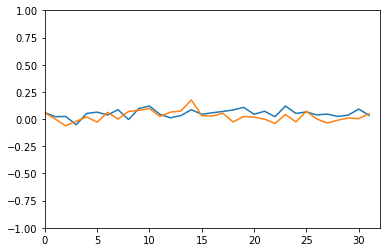

In [23]:
plt.plot(x_vals_control_off)
plt.plot(x_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

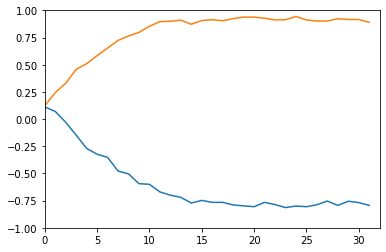

In [24]:
plt.plot(y_vals_control_off)
plt.plot(y_vals_control_on)
plt.axis([0, 32, -1, 1])

[0, 32, -1, 1]

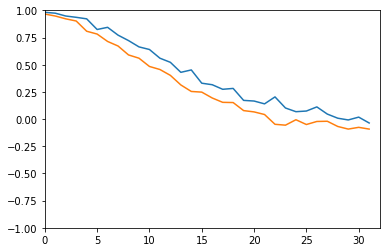

In [25]:
plt.plot(z_vals_control_off)
plt.plot(z_vals_control_on)
plt.axis([0, 32, -1, 1])

In [18]:
list(zip(range(32), np.linspace(0, 3*np.pi/4, 32, endpoint=False)))

[(0, 0.0),
 (1, 0.07363107781851078),
 (2, 0.14726215563702155),
 (3, 0.22089323345553233),
 (4, 0.2945243112740431),
 (5, 0.36815538909255385),
 (6, 0.44178646691106466),
 (7, 0.5154175447295755),
 (8, 0.5890486225480862),
 (9, 0.662679700366597),
 (10, 0.7363107781851077),
 (11, 0.8099418560036186),
 (12, 0.8835729338221293),
 (13, 0.9572040116406401),
 (14, 1.030835089459151),
 (15, 1.1044661672776617),
 (16, 1.1780972450961724),
 (17, 1.2517283229146832),
 (18, 1.325359400733194),
 (19, 1.3989904785517047),
 (20, 1.4726215563702154),
 (21, 1.5462526341887264),
 (22, 1.6198837120072371),
 (23, 1.6935147898257479),
 (24, 1.7671458676442586),
 (25, 1.8407769454627694),
 (26, 1.9144080232812801),
 (27, 1.9880391010997909),
 (28, 2.061670178918302),
 (29, 2.1353012567368124),
 (30, 2.2089323345553233),
 (31, 2.282563412373834)]